In [20]:
import torch
import torch.nn as nn
import torch.functional as F
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from batchbald_redux import repeated_mnist, active_learning, batchbald
from main.models import BayesianConvNet
from main.utils import save_experiment, load_experiment


%reload_ext autoreload
%autoreload 2

In [2]:
# loading data
train_dataset, test_dataset = repeated_mnist.create_MNIST_dataset()

# number of initial samples 
num_initial_samples = 40
num_classes = 10

# get indices of initial samples
initial_samples = active_learning.get_balanced_sample_indices(
    repeated_mnist.get_targets(train_dataset), num_classes=num_classes, n_per_digit=num_initial_samples / num_classes
)

# Experiment parameters
max_training_samples = 100  # Maximum number of samples to acquire from the pool dataset 
acquisition_batch_size = 5  # Number of samples to acquire in each acquisition step
num_inference_samples = 50  # Number of samples to use for inference in MC-Dropout
num_test_inference_samples = 5  
num_samples = 100000 # Number of samples to use for estimation in batchbald

test_batch_size = 512  # Batch size for testing
batch_size = 64  # Batch size for training
scoring_batch_size = 128  # Batch size for scoring 
training_iterations = 4096 * 6 # Number of training iterations (batches) to run

kwargs = {"num_workers": 1, "pin_memory": True}

use_cuda = torch.cuda.is_available()
device = "cuda" if use_cuda else "cpu"

print(f"use_cuda: {use_cuda}")

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, **kwargs)

active_learning_data = active_learning.ActiveLearningData(train_dataset)

# Split off the initial samples first.
active_learning_data.acquire(initial_samples)

# THIS REMOVES MOST OF THE POOL DATA. UNCOMMENT THIS TO TAKE ALL UNLABELLED DATA INTO ACCOUNT!
active_learning_data.extract_dataset_from_pool(55000)

train_loader = torch.utils.data.DataLoader(
    active_learning_data.training_dataset,
    sampler=active_learning.RandomFixedLengthSampler(active_learning_data.training_dataset, training_iterations),
    batch_size=batch_size,
    **kwargs,
)

pool_loader = torch.utils.data.DataLoader(
    active_learning_data.pool_dataset, batch_size=scoring_batch_size, shuffle=False, **kwargs
)

use_cuda: False


c:\Users\vince\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\sampler.py:64: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn("`data_source` argument is not used and will be removed in 2.2.0."


In [3]:
print(f"Initial samples: {len(initial_samples)}")
print(f"Training samples: {len(active_learning_data.training_dataset)}")
print(f"Pool samples: {len(active_learning_data.pool_dataset)}")
print(f"Test samples: {len(test_dataset)}\n")

print(f"Train loader: {len(train_loader)}")
print(f"Test loader: {len(test_loader)}")
print(f"Pool loader: {len(pool_loader)}")

Initial samples: 40
Training samples: 40
Pool samples: 4960
Test samples: 10000

Train loader: 384
Test loader: 20
Pool loader: 39


In [4]:
# Run experiment
test_accs = []
test_loss = []
added_indices = []

pbar = tqdm(initial=len(active_learning_data.training_dataset), total=max_training_samples, desc="Training Set Size")
loss_fn = nn.NLLLoss()

while True:
    model = BayesianConvNet(num_classes).to(device=device)
    optimizer = torch.optim.Adam(model.parameters())

    model.train()

    # Train
    for data, target in tqdm(train_loader, desc="Training", leave=False):
        data = data.to(device=device)
        target = target.to(device=device)

        optimizer.zero_grad()

        prediction = model(data, 1).squeeze(1)
        loss = loss_fn(prediction, target)

        loss.backward()
        optimizer.step()

    # Test
    loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in tqdm(test_loader, desc="Testing", leave=False):
            data = data.to(device=device)
            target = target.to(device=device)

            prediction = torch.logsumexp(model(data, num_test_inference_samples), dim=1) - math.log(
                num_test_inference_samples
            )
            loss += loss_fn(prediction, target)

            prediction = prediction.max(1)[1]
            correct += prediction.eq(target.view_as(prediction)).sum().item()

    loss /= len(test_loader.dataset)
    test_loss.append(loss)

    percentage_correct = 100.0 * correct / len(test_loader.dataset)
    test_accs.append(percentage_correct)

    print(
        "Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)".format(
            loss, correct, len(test_loader.dataset), percentage_correct
        )
    )

    if len(active_learning_data.training_dataset) >= max_training_samples:
        break

    # Acquire pool predictions
    N = len(active_learning_data.pool_dataset)
    logits_N_K_C = torch.empty((N, num_inference_samples, num_classes), dtype=torch.double, pin_memory=use_cuda)

    with torch.no_grad():
        model.eval()

        for i, (data, _) in enumerate(tqdm(pool_loader, desc="Evaluating Acquisition Set", leave=False)):
            data = data.to(device=device)

            lower = i * pool_loader.batch_size
            upper = min(lower + pool_loader.batch_size, N)
            logits_N_K_C[lower:upper].copy_(model(data, num_inference_samples).double(), non_blocking=True)

    with torch.no_grad():
        candidate_batch = batchbald.get_batchbald_batch(
            logits_N_K_C, acquisition_batch_size, num_samples, dtype=torch.double, device=device
        )

    targets = repeated_mnist.get_targets(active_learning_data.pool_dataset)
    dataset_indices = active_learning_data.get_dataset_indices(candidate_batch.indices)

    print("Dataset indices: ", dataset_indices)
    print("Scores: ", candidate_batch.scores)
    print("Labels: ", targets[candidate_batch.indices])

    active_learning_data.acquire(candidate_batch.indices)
    added_indices.append(dataset_indices)
    pbar.update(len(dataset_indices))

Training Set Size:  40%|████      | 40/100 [00:00<?, ?it/s]

Test set: Average loss: 0.0024, Accuracy: 7252/10000 (72.52%)


Conditional Entropy: 100%|██████████| 4960/4960 [00:00<00:00, 6407.81it/s]





























Training Set Size:  45%|████▌     | 45/100 [01:16<14:03, 15.33s/it]

Dataset indices:  [38908 28632 29634  6929 34220]
Scores:  [1.338925500792432, 2.430822404989989, 3.1119289192927386, 3.521352625917851, 3.7245493775134118]
Labels:  tensor([7, 7, 8, 5, 6])


Test set: Average loss: 0.0022, Accuracy: 7380/10000 (73.80%)


Conditional Entropy: 100%|██████████| 4955/4955 [00:00<00:00, 9771.01it/s] 





























Training Set Size:  50%|█████     | 50/100 [02:23<11:50, 14.21s/it]

Dataset indices:  [ 4469 32678 10070  1272 30028]
Scores:  [1.2242878983729861, 2.2987123539855996, 3.0560331398637777, 3.448086633023932, 3.675543097800706]
Labels:  tensor([2, 2, 9, 9, 5])


Test set: Average loss: 0.0018, Accuracy: 7744/10000 (77.44%)


Conditional Entropy: 100%|██████████| 4950/4950 [00:00<00:00, 8634.06it/s] 





























Training Set Size:  55%|█████▌    | 55/100 [03:31<10:25, 13.91s/it]

Dataset indices:  [41816  4723   667 13604 44882]
Scores:  [1.1878066289433364, 2.1563662015648806, 2.8698494651105433, 3.331835636620614, 3.6077869390460235]
Labels:  tensor([1, 5, 0, 1, 9])


Test set: Average loss: 0.0019, Accuracy: 7623/10000 (76.23%)


Conditional Entropy: 100%|██████████| 4945/4945 [00:00<00:00, 9645.67it/s] 




























Training Set Size:  60%|██████    | 60/100 [04:35<08:59, 13.49s/it]

Dataset indices:  [22191 44506 26434 55602 16009]
Scores:  [1.1503709351029032, 2.194914383114521, 2.9987584670231664, 3.4089718030137677, 3.643275153790226]
Labels:  tensor([6, 5, 2, 5, 4])


Test set: Average loss: 0.0015, Accuracy: 8036/10000 (80.36%)


Conditional Entropy: 100%|██████████| 4940/4940 [00:00<00:00, 9198.09it/s] 





























Training Set Size:  65%|██████▌   | 65/100 [05:43<07:52, 13.49s/it]

Dataset indices:  [39006 18712 26460 25321 37986]
Scores:  [1.142152232692104, 2.122723489662044, 2.8537618689921995, 3.342190149766407, 3.6197354632752066]
Labels:  tensor([2, 0, 5, 8, 4])


Test set: Average loss: 0.0012, Accuracy: 8366/10000 (83.66%)


Conditional Entropy: 100%|██████████| 4935/4935 [00:00<00:00, 9095.86it/s] 





























Training Set Size:  70%|███████   | 70/100 [06:48<06:40, 13.35s/it]

Dataset indices:  [20363 14383 36067 52422 23140]
Scores:  [1.139282027641505, 2.0797545609417583, 2.794025113330806, 3.278992223077787, 3.5811683891642216]
Labels:  tensor([8, 3, 6, 2, 7])


Test set: Average loss: 0.0012, Accuracy: 8279/10000 (82.79%)


Conditional Entropy: 100%|██████████| 4930/4930 [00:00<00:00, 9403.53it/s] 





























Training Set Size:  75%|███████▌  | 75/100 [07:51<05:27, 13.11s/it]

Dataset indices:  [44948 17494   485 38577 51173]
Scores:  [1.2107341536872485, 2.2261498595720535, 2.9592617861585033, 3.394698444614821, 3.628964077044337]
Labels:  tensor([9, 5, 8, 5, 3])


Test set: Average loss: 0.0011, Accuracy: 8360/10000 (83.60%)


Conditional Entropy: 100%|██████████| 4925/4925 [00:00<00:00, 9247.34it/s] 





























Training Set Size:  80%|████████  | 80/100 [08:57<04:23, 13.15s/it]

Dataset indices:  [24623 58437 52972 13093 29761]
Scores:  [1.1795731016250557, 2.0822489834133124, 2.787329049508088, 3.2595805800931674, 3.5384016735237322]
Labels:  tensor([2, 9, 3, 3, 4])


Test set: Average loss: 0.0010, Accuracy: 8500/10000 (85.00%)


Conditional Entropy: 100%|██████████| 4920/4920 [00:00<00:00, 9026.21it/s] 






























Training Set Size:  85%|████████▌ | 85/100 [10:02<03:16, 13.10s/it]

Dataset indices:  [52688 42316 27427 17486 53358]
Scores:  [1.1088586802312212, 2.021268258259589, 2.7688920130080463, 3.2634877091469123, 3.5420820864821234]
Labels:  tensor([6, 1, 0, 7, 3])


Test set: Average loss: 0.0009, Accuracy: 8795/10000 (87.95%)


Conditional Entropy: 100%|██████████| 4915/4915 [00:00<00:00, 9216.07it/s] 





























Training Set Size:  90%|█████████ | 90/100 [11:07<02:10, 13.05s/it]

Dataset indices:  [11657 44350 13796 53298 50981]
Scores:  [1.182288444772227, 2.1227419608602958, 2.81752576584561, 3.2840130728530994, 3.583594085153435]
Labels:  tensor([0, 3, 5, 0, 4])


Test set: Average loss: 0.0008, Accuracy: 8847/10000 (88.47%)


Conditional Entropy: 100%|██████████| 4910/4910 [00:00<00:00, 9560.18it/s] 





























Training Set Size:  95%|█████████▌| 95/100 [12:10<01:04, 12.94s/it]

Dataset indices:  [45521 41266 54954 57575 22717]
Scores:  [1.0439184720529877, 2.0097203587300374, 2.7534652680920577, 3.276515315484198, 3.5540499352958568]
Labels:  tensor([7, 1, 8, 0, 3])


Test set: Average loss: 0.0008, Accuracy: 8826/10000 (88.26%)


Conditional Entropy: 100%|██████████| 4905/4905 [00:00<00:00, 8923.93it/s] 





























Training Set Size: 100%|██████████| 100/100 [13:19<00:00, 13.20s/it]

Dataset indices:  [29911 43815 57985 28183 58812]
Scores:  [1.1518326824184724, 2.0834940151196775, 2.788841058678677, 3.2784431363615214, 3.545404069901215]
Labels:  tensor([2, 2, 4, 9, 3])


Test set: Average loss: 0.0008, Accuracy: 8928/10000 (89.28%)


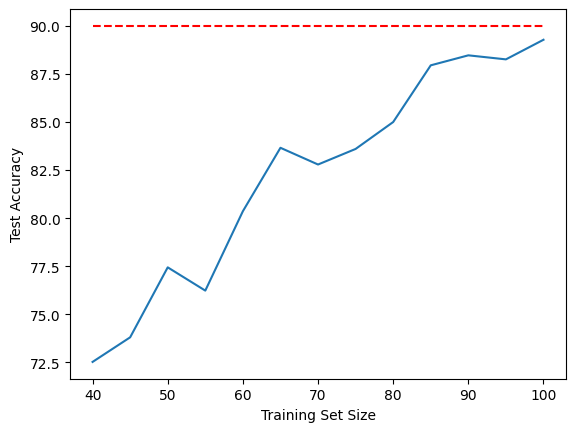

In [13]:
plt.plot(np.arange(start=num_initial_samples, stop=max_training_samples + acquisition_batch_size, step=acquisition_batch_size), test_accs)
plt.xlabel("Training Set Size")
plt.ylabel("Test Accuracy")
plt.hlines(90, num_initial_samples, max_training_samples, colors='r', linestyles='dashed')

plt.show()

## Storing results

In [18]:
params_dict = {
    'num_initial_samples': num_initial_samples,
    'num_classes': num_classes,
    'max_training_samples': max_training_samples,
    'acquisition_batch_size': acquisition_batch_size,
    'num_inference_samples': num_inference_samples,
    'num_test_inference_samples': num_test_inference_samples,
    'num_samples': num_samples,
    'test_batch_size': test_batch_size,
    'batch_size': batch_size,
    'scoring_batch_size': scoring_batch_size,
    'training_iterations': training_iterations
}

save_experiment('Lenet5-simple', params_dict, {
    'test_accs': test_accs,
    'test_loss': test_loss,
    'added_indices': added_indices
})